# ИМПОРТ ПАКЕТОВ

In [102]:
# Дла работы с табличными данными
import pandas as pd
# Для работы с массивами и математическими операциями
import numpy as np

# Для визуализации
import matplotlib
import matplotlib.pyplot as plt
# Эта строчка задает определенный стиль картинок
matplotlib.style.use('ggplot')
# matplotlib Inline позволяет выводить график в каждой отдельной ячейки для всего ноутбука
%matplotlib inline

# # Для построения PACF, ACF и линейной модели
# import statsmodels.api as sm
# # import statsmodels.formula.api as smf
import statsmodels.api as sm

# # Для использования exp
from math import log
import arch

import warnings # Чтобы не выводились предупреждения

# Загрузка данных

In [103]:
df_cpi = pd.read_csv(r'C:\Users\User\Downloads\Прошлые данные - GAZP (3).csv')

df_cpi['Дата'] = pd.to_datetime(df_cpi['Дата'],format="%d.%m.%Y" )

df_cpi = df_cpi.astype({'CPI': float})
df_cpi['d1CPI'] = df_cpi['CPI'].diff(periods = 1)
df_cpi['d2CPI'] = df_cpi['CPI'].diff(periods = 2)
df_cpi['d3CPI'] = df_cpi['CPI'].diff(periods = 3)
df_cpi.head()

df_d1CPI = df_cpi[['d1CPI']][1:].reset_index(drop = True)

for i in range(1, 7):
    df_d1CPI['d1CPI_l' + str(i)] = [0]*i + df_d1CPI['d1CPI'][:-i].tolist()
from statsmodels.tsa.stattools import adfuller

adfuller(df_cpi['CPI'], regression = 'c', maxlag = 1)

(-2.5432858736822537,
 0.10529438584826945,
 1,
 4258,
 {'1%': -3.431886694835031,
  '5%': -2.862219026907463,
  '10%': -2.567131451315028},
 25743.015699287775)

 p-value > 0.05 => Нет оснований отвергнуть гипотезу о существовании единичного корня => ряд не стационарен


In [104]:

adfuller(df_d1CPI['d1CPI'], regression = 'c', maxlag = 4)

# regression = 'c' - спецификация "константа без тренда"


(-45.15486090381463,
 0.0,
 1,
 4257,
 {'1%': -3.431887056033751,
  '5%': -2.8622191864708943,
  '10%': -2.5671315362589517},
 25716.83301661467)

p-value < 0.05 => Отвергаем гипотезу о существовании единичного корня => ряд стационарен

In [105]:
df_cpi

,Дата,CPI,d1CPI,d2CPI,d3CPI
0,2006-01-24,224.00,NaN,NaN,NaN
1,2006-01-25,228.38,4.38,NaN,NaN
2,2006-01-26,224.47,-3.91,0.47,NaN
3,2006-01-27,228.75,4.28,0.37,4.75
4,2006-01-30,216.00,-12.75,-8.47,-12.38
...,...,...,...,...,...
4255,2023-02-06,160.14,-0.73,2.04,2.02
4256,2023-02-07,159.87,-0.27,-1.00,1.77
4257,2023-02-08,158.18,-1.69,-1.96,-2.69
4258,2023-02-09,159.19,1.01,-0.68,-0.95


# Создание ARIMA

In [106]:
import pmdarima as pm

arima_model_cpi = pm.auto_arima(df_d1CPI['d1CPI'], trend = 't')
print(arima_model_cpi.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4259
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -12872.359
Date:                Mon, 13 Feb 2023   AIC                          25752.718
Time:                        20:06:38   BIC                          25778.145
Sample:                             0   HQIC                         25761.702
                               - 4259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -5.084e-06   3.12e-05     -0.163      0.871   -6.62e-05    5.61e-05
ar.L1         -0.0229      0.006     -3.548      0.000      -0.036      -0.010
ar.L2          0.0329      0.005      6.459      0.0

In [107]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_d1CPI['d1CPI'], trend = 't', order = (2,1,0))
arima_model = arima_model.fit()

arima_model_cpi = ARIMA(df_cpi['CPI'], trend = 't', order = (2,1,0))
arima_model_cpi = arima_model_cpi.fit()
print(arima_model_cpi.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                 4260
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -12872.352
Date:                Mon, 13 Feb 2023   AIC                          25752.705
Time:                        20:06:39   BIC                          25778.132
Sample:                             0   HQIC                         25761.689
                               - 4260                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0153      0.084     -0.183      0.855      -0.179       0.149
ar.L1         -0.0231      0.006     -3.557      0.000      -0.036      -0.010
ar.L2          0.0329      0.005      6.418      0.0

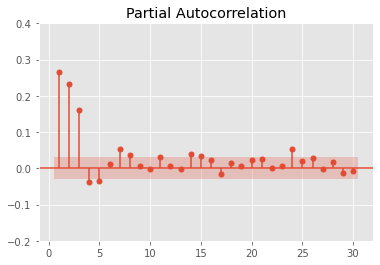

In [108]:
sm.graphics.tsa.plot_pacf(arima_model.resid**2, method = 'ywm', zero = False, alpha = 0.05, lags = 30) # Строим PACF
plt.ylim((-0.2 ,0.4)) # Ограничиваем ось Y
plt.show() # Выводим график

Вывод: допустимы альтернативы ARCH[6]-ARCH[2]


### Проверка нормальности остатков


In [109]:
from scipy.stats import shapiro

shapiro(arima_model.resid)

ShapiroResult(statistic=0.8090219497680664, pvalue=0.0)

Не можем отвергнуть гипотезу, что остатки не нормальны.
Будем брать распределение Стьюдента.

# GARCH[2,2] + ARIMA[2,1] (d1)

In [110]:
model_arch_11 = arch.univariate.arch_model(arima_model.resid, mean = 'Constant',vol = 'GARCH', p = 2, q = 2,dist = 'normal')

res_11 = model_arch_11.fit()

lag = int(log(len(res_11.resid))) # Число степеней свободы - логарифм по времени
p = 4
model_df = p
sm.stats.acorr_ljungbox(res_11.resid, lags=[lag], model_df = p)
sm.stats.acorr_ljungbox(res_11.resid**2, lags=[lag], model_df = p)
print(res_11.summary())
# На какой период хотим сроить прогноз?

Iteration:      1,   Func. Count:      8,   Neg. LLF: 35179.820708219035
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13472.752811710227
Iteration:      3,   Func. Count:     26,   Neg. LLF: 12066.334915249154
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2046488.4553515539
Iteration:      5,   Func. Count:     43,   Neg. LLF: 12063.181649668692
Iteration:      6,   Func. Count:     51,   Neg. LLF: 12074.677559266467
Iteration:      7,   Func. Count:     59,   Neg. LLF: 12101.911195563835
Iteration:      8,   Func. Count:     67,   Neg. LLF: 12142.175965298578
Iteration:      9,   Func. Count:     75,   Neg. LLF: 12048.2528975661
Iteration:     10,   Func. Count:     83,   Neg. LLF: 12014.389169114555
Iteration:     11,   Func. Count:     91,   Neg. LLF: 11951.04213290823
Iteration:     12,   Func. Count:     99,   Neg. LLF: 11958.737081843496
Iteration:     13,   Func. Count:    107,   Neg. LLF: 11948.610991985377
Iteration:     14,   Func. Count:    114,   Neg. LLF: 

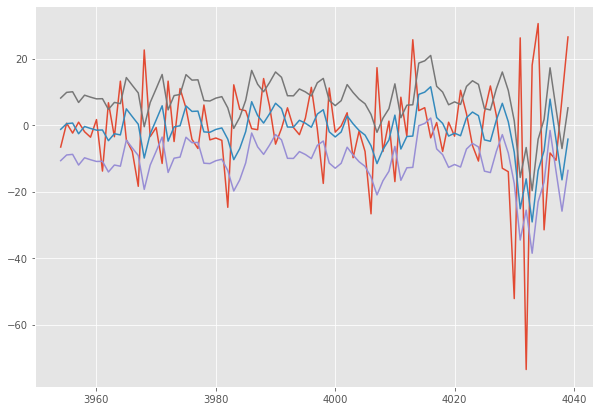

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11948.4
Distribution:                  Normal   AIC:                           23908.8
Method:            Maximum Likelihood   BIC:                           23946.9
                                        No. Observations:                 4259
Date:                Mon, Feb 13 2023   Df Residuals:                     4258
Time:                        20:06:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0404  4.691e-02      0.861      0.389 [-5.15

In [111]:
horizon = 86
# Предсказание по модели ARMA
y_pred_arima = arima_model.get_prediction(horizon)
yhat = y_pred_arima.predicted_mean
yhat_up = y_pred_arima.conf_int(alpha=0.1)['lower d1CPI']
yhat_dn = y_pred_arima.conf_int(alpha=0.1)['upper d1CPI']

# Предсказание по модели ARHC для остатков
e_pred_arch  = res_11.forecast(horizon=horizon, reindex=False)
e_pred_arch = e_pred_arch.mean # Средний прогноз

conf_int = pd.DataFrame(e_pred_arch.values).T
conf_int.columns = ['ehat']
conf_int.index = list(range(3954,4040))

yhat = yhat.dropna ()

# Общий прогноз
yhat =conf_int['ehat']+yhat
yhat_up = yhat_up + conf_int['ehat']
yhat_dn = yhat_dn + conf_int['ehat']

yhat = yhat.dropna ()

y_pred = yhat
y_test = df_d1CPI['d1CPI']
y_test=y_test.iloc[3954:4040]
y_test

# Оценим качество прогноза для ряда первых остатков
plt.figure(figsize = (10, 7))

# График ряда
plt.plot(y_test, label = 'Train')

# График прогноза
plt.plot(y_pred, label = 'yhat')

plt.plot(yhat_up, label = 'yhat_up')

plt.plot(yhat_dn, label = 'yhat_dn')

plt.show()

print(res_11.summary())

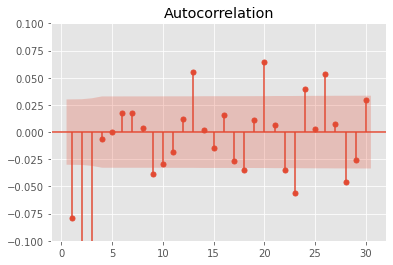

,lb_stat,lb_pvalue
8,414.031528,2.583998e-88


In [112]:
sm.graphics.tsa.plot_acf(res_11.resid, zero = False, alpha = 0.05, lags = 30) # Строим ACF
plt.ylim((-0.1 ,0.1)) # Ограничиваем ось Y
plt.show() # Выводим график

lag = int(log(len(res_11.resid))) # Число степеней свободы - логарифм по времени
p = 4
model_df = p

sm.stats.acorr_ljungbox(res_11.resid, lags=[lag], model_df = p)

Предсказание на будущее

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20356.581158579935
Iteration:      2,   Func. Count:     20,   Neg. LLF: 33171.08526507077
Iteration:      3,   Func. Count:     30,   Neg. LLF: 16581.78230668402
Iteration:      4,   Func. Count:     40,   Neg. LLF: 11947.99144937969
Iteration:      5,   Func. Count:     49,   Neg. LLF: 11837.855688626172
Iteration:      6,   Func. Count:     58,   Neg. LLF: 11941.51348415131
Iteration:      7,   Func. Count:     67,   Neg. LLF: 16532.708353576025
Iteration:      8,   Func. Count:     77,   Neg. LLF: 11802.078104403812
Iteration:      9,   Func. Count:     86,   Neg. LLF: 11727.481082252249
Iteration:     10,   Func. Count:     94,   Neg. LLF: 11756.151962357515
Iteration:     11,   Func. Count:    103,   Neg. LLF: 11727.336347340311
Iteration:     12,   Func. Count:    112,   Neg. LLF: 11727.159668907223
Iteration:     13,   Func. Count:    120,   Neg. LLF: 11727.153297044726
Iteration:     14,   Func. Count:    128,   Neg. LLF: 1

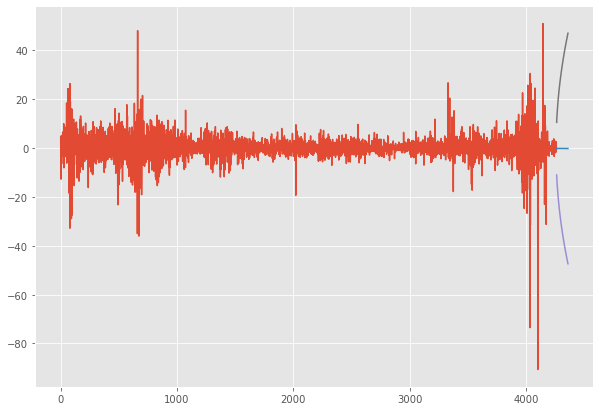

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -11727.2
Distribution:      Standardized Student's t   AIC:                           23468.3
Method:                  Maximum Likelihood   BIC:                           23512.8
                                              No. Observations:                 4259
Date:                      Mon, Feb 13 2023   Df Residuals:                     4258
Time:                              20:06:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [113]:
model_arch_11 = arch.univariate.arch_model(arima_model.resid, mean = 'Constant',vol = 'GARCH', p = 2, q = 2,dist = 'studentst')

res_11 = model_arch_11.fit()
res_11

horizon = 100
# Предсказание по модели ARMA
y_pred_arima = arima_model.get_forecast(horizon)
yhat = y_pred_arima.predicted_mean
yhat_up = y_pred_arima.conf_int(alpha=0.1)['lower d1CPI']
yhat_dn = y_pred_arima.conf_int(alpha=0.1)['upper d1CPI']

# Предсказание по модели ARHC для остатков
e_pred_arch  = res_11.forecast(horizon=horizon, reindex=False)
e_pred_arch = e_pred_arch.mean # Средний прогноз

conf_int = pd.DataFrame(e_pred_arch.values).T
conf_int.columns = ['ehat']
conf_int.index = list(range(4261,4361))

yhat = yhat.dropna ()

# Общий прогноз
yhat =conf_int['ehat']+yhat
yhat_up = yhat_up + conf_int['ehat']
yhat_dn = yhat_dn + conf_int['ehat']

yhat = yhat.dropna ()

y_pred = yhat
y_test = df_d1CPI['d1CPI']
y_test

# Оценим качество прогноза для ряда первых остатков
plt.figure(figsize = (10, 7))

# График ряда
plt.plot(y_test, label = 'Train')

# График прогноза
plt.plot(y_pred, label = 'yhat')

plt.plot(yhat_up, label = 'yhat_up')

plt.plot(yhat_dn, label = 'yhat_dn')

plt.show()

print(res_11.summary())

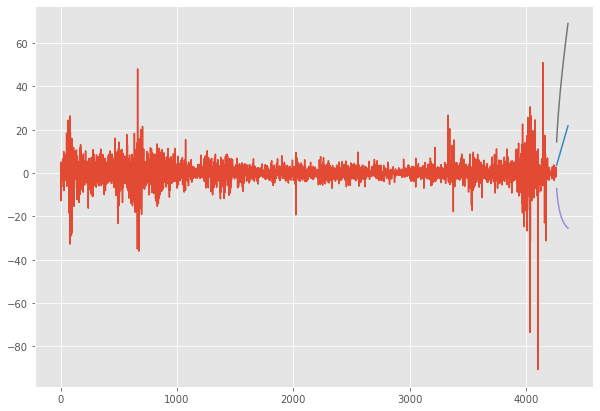

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -11727.2
Distribution:      Standardized Student's t   AIC:                           23468.3
Method:                  Maximum Likelihood   BIC:                           23512.8
                                              No. Observations:                 4259
Date:                      Mon, Feb 13 2023   Df Residuals:                     4258
Time:                              20:06:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [114]:
horizon = 100
# Предсказание по модели ARMA
y_pred_arima = arima_model.get_forecast(horizon)
yhat = y_pred_arima.predicted_mean
yhat_up = y_pred_arima.conf_int(alpha=0.1)['lower d1CPI']
yhat_dn = y_pred_arima.conf_int(alpha=0.1)['upper d1CPI']

# Предсказание по модели ARHC для остатков
e_pred_arch  = res_11.forecast(horizon=horizon, reindex=False)
e_pred_arch = e_pred_arch.residual_variance # Средний прогноз

conf_int = pd.DataFrame(e_pred_arch.values).T
conf_int.columns = ['ehat']
conf_int.index = list(range(4261,4361))

yhat = yhat.dropna ()

# Общий прогноз
yhat =conf_int['ehat']+yhat
yhat_up = yhat_up + conf_int['ehat']
yhat_dn = yhat_dn + conf_int['ehat']

yhat = yhat.dropna ()

y_pred = yhat
y_test = df_d1CPI['d1CPI']
y_test

# Оценим качество прогноза для ряда первых остатков
plt.figure(figsize = (10, 7))

# График ряда
plt.plot(y_test, label = 'Train')

# График прогноза
plt.plot(y_pred, label = 'yhat')

plt.plot(yhat_up, label = 'yhat_up')

plt.plot(yhat_dn, label = 'yhat_dn')

plt.show()

print(res_11.summary())

# GARCH + ARIMA (Исходник)

Предсказание на кризис

Iteration:      1,   Func. Count:      9,   Neg. LLF: 103530.18247253782
Iteration:      2,   Func. Count:     20,   Neg. LLF: 75115.51100233982
Iteration:      3,   Func. Count:     30,   Neg. LLF: 22608.38706578553
Iteration:      4,   Func. Count:     39,   Neg. LLF: 11274.048085669096
Iteration:      5,   Func. Count:     48,   Neg. LLF: 14424.857763161155
Iteration:      6,   Func. Count:     57,   Neg. LLF: 11397.82197502225
Iteration:      7,   Func. Count:     66,   Neg. LLF: 11310.906045654885
Iteration:      8,   Func. Count:     75,   Neg. LLF: 11145.836331512159
Iteration:      9,   Func. Count:     83,   Neg. LLF: 11146.501075060978
Iteration:     10,   Func. Count:     92,   Neg. LLF: 11146.356556063825
Iteration:     11,   Func. Count:    101,   Neg. LLF: 11144.690561063613
Iteration:     12,   Func. Count:    109,   Neg. LLF: 11144.646975295716
Iteration:     13,   Func. Count:    117,   Neg. LLF: 11144.630529734777
Iteration:     14,   Func. Count:    125,   Neg. LLF: 

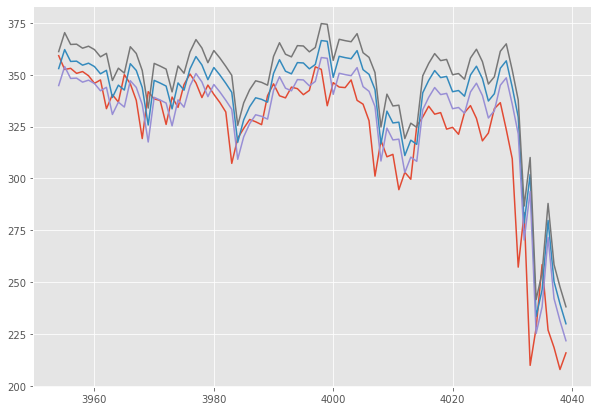

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -11144.6
Distribution:      Standardized Student's t   AIC:                           22303.2
Method:                  Maximum Likelihood   BIC:                           22347.7
                                              No. Observations:                 4260
Date:                      Mon, Feb 13 2023   Df Residuals:                     4259
Time:                              20:06:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [115]:
# ARCH на остатках
model_arch_11 = arch.univariate.arch_model(arima_model_cpi.resid, mean = 'Constant',vol = 'GARCH', p = 2,q=2, dist = 'studentst')

res_11 = model_arch_11.fit()
# Предсказание по модели ARMA
horizon = 86
y_pred_arima = arima_model_cpi.get_prediction(horizon)
yhat = y_pred_arima.predicted_mean
yhat_up = y_pred_arima.conf_int(alpha=0.1)['lower CPI']
yhat_dn = y_pred_arima.conf_int(alpha=0.1)['upper CPI']

# Предсказание по модели ARHC
e_pred_arch  = res_11.forecast(horizon=horizon, reindex=False)
e_pred_arch = e_pred_arch.residual_variance # Средний прогноз

conf_int = pd.DataFrame(e_pred_arch.values).T
conf_int.columns = ['ehat']
conf_int.index = list(range(3954,4040))

yhat_up = yhat_up.dropna()

# Общий прогноз
yhat = conf_int['ehat'] + yhat
yhat_up = yhat_up + conf_int['ehat']
yhat_dn = yhat_dn + conf_int['ehat']

y_pred = yhat.dropna()
y_test = df_cpi['CPI']
y_test=y_test.iloc[3954:4040]
y_pred

# Оценим качество прогноза для ряда первых остатков
plt.figure(figsize = (10, 7))

# График ряда
plt.plot(y_test, label = 'Train')

# График прогноза
plt.plot(y_pred, label = 'yhat')

plt.plot(yhat_up, label = 'yhat_up')

plt.plot(yhat_dn, label = 'yhat_dn')

plt.show()


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_pred, y_test)
mse
print(res_11.summary())

Автокорреляция

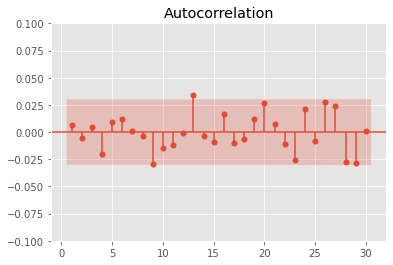

,lb_stat,lb_pvalue
8,3.184044,0.527512


In [116]:
sm.graphics.tsa.plot_acf(res_11.resid, zero = False, alpha = 0.05, lags = 30) # Строим ACF
plt.ylim((-0.1 ,0.1)) # Ограничиваем ось Y
plt.show() # Выводим график

lag = int(log(len(res_11.resid))) # Число степеней свободы - логарифм по времени
p = 4
model_df = p

sm.stats.acorr_ljungbox(res_11.resid, lags=[lag], model_df = p)

# Метод resid хранит остатки модели

Предсказание на будущее

Iteration:      1,   Func. Count:      9,   Neg. LLF: 103530.18247253782
Iteration:      2,   Func. Count:     20,   Neg. LLF: 75115.51100233982
Iteration:      3,   Func. Count:     30,   Neg. LLF: 22608.38706578553
Iteration:      4,   Func. Count:     39,   Neg. LLF: 11274.048085669096
Iteration:      5,   Func. Count:     48,   Neg. LLF: 14424.857763161155
Iteration:      6,   Func. Count:     57,   Neg. LLF: 11397.82197502225
Iteration:      7,   Func. Count:     66,   Neg. LLF: 11310.906045654885
Iteration:      8,   Func. Count:     75,   Neg. LLF: 11145.836331512159
Iteration:      9,   Func. Count:     83,   Neg. LLF: 11146.501075060978
Iteration:     10,   Func. Count:     92,   Neg. LLF: 11146.356556063825
Iteration:     11,   Func. Count:    101,   Neg. LLF: 11144.690561063613
Iteration:     12,   Func. Count:    109,   Neg. LLF: 11144.646975295716
Iteration:     13,   Func. Count:    117,   Neg. LLF: 11144.630529734777
Iteration:     14,   Func. Count:    125,   Neg. LLF: 

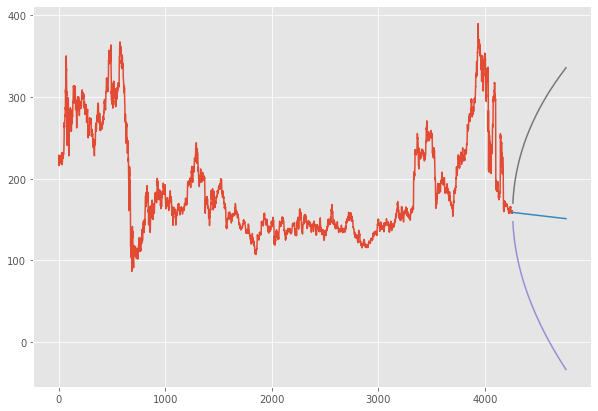

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -11144.6
Distribution:      Standardized Student's t   AIC:                           22303.2
Method:                  Maximum Likelihood   BIC:                           22347.7
                                              No. Observations:                 4260
Date:                      Mon, Feb 13 2023   Df Residuals:                     4259
Time:                              20:06:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [117]:
model_arch_11 = arch.univariate.arch_model(arima_model_cpi.resid, mean = 'Constant',vol = 'GARCH', p = 2, q = 2,dist = 'studentst')

res_11 = model_arch_11.fit()

horizon = 500
# Предсказание по модели ARMA
y_pred_arima = arima_model_cpi.get_forecast(horizon)
yhat = y_pred_arima.predicted_mean
yhat_up = y_pred_arima.conf_int(alpha=0.1)['lower CPI']
yhat_dn = y_pred_arima.conf_int(alpha=0.1)['upper CPI']

# Предсказание по модели ARHC для остатков
e_pred_arch  = res_11.forecast(horizon=horizon, reindex=False)
e_pred_arch = e_pred_arch.mean # Средний прогноз

conf_int = pd.DataFrame(e_pred_arch.values).T
conf_int.columns = ['ehat']
conf_int.index = list(range(4261,4761))

yhat = yhat.dropna ()

# Общий прогноз
yhat =conf_int['ehat']+yhat
yhat_up = yhat_up + conf_int['ehat']
yhat_dn = yhat_dn + conf_int['ehat']

yhat = yhat.dropna ()

y_pred = yhat
y_test = df_cpi['CPI']
y_test

# Оценим качество прогноза для ряда первых остатков
plt.figure(figsize = (10, 7))

# График ряда
plt.plot(y_test, label = 'Train')

# График прогноза
plt.plot(y_pred, label = 'yhat')

plt.plot(yhat_up, label = 'yhat_up')

plt.plot(yhat_dn, label = 'yhat_dn')

plt.show()

print(res_11.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 103530.18247253782
Iteration:      2,   Func. Count:     20,   Neg. LLF: 75115.51100233982
Iteration:      3,   Func. Count:     30,   Neg. LLF: 22608.38706578553
Iteration:      4,   Func. Count:     39,   Neg. LLF: 11274.048085669096
Iteration:      5,   Func. Count:     48,   Neg. LLF: 14424.857763161155
Iteration:      6,   Func. Count:     57,   Neg. LLF: 11397.82197502225
Iteration:      7,   Func. Count:     66,   Neg. LLF: 11310.906045654885
Iteration:      8,   Func. Count:     75,   Neg. LLF: 11145.836331512159
Iteration:      9,   Func. Count:     83,   Neg. LLF: 11146.501075060978
Iteration:     10,   Func. Count:     92,   Neg. LLF: 11146.356556063825
Iteration:     11,   Func. Count:    101,   Neg. LLF: 11144.690561063613
Iteration:     12,   Func. Count:    109,   Neg. LLF: 11144.646975295716
Iteration:     13,   Func. Count:    117,   Neg. LLF: 11144.630529734777
Iteration:     14,   Func. Count:    125,   Neg. LLF: 

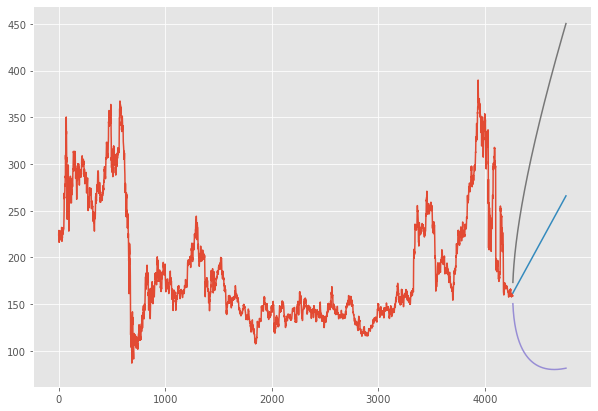

ValueError: Found input variables with inconsistent numbers of samples: [499, 4260]

In [118]:
# ARCH на остатках
model_arch_11 = arch.univariate.arch_model(arima_model_cpi.resid, mean = 'Constant',vol = 'GARCH', p = 2,q=2, dist = 'studentst')

res_11 = model_arch_11.fit()
# Предсказание по модели ARMA
horizon = 500
y_pred_arima = arima_model_cpi.get_forecast(horizon)
yhat = y_pred_arima.predicted_mean
yhat_up = y_pred_arima.conf_int(alpha=0.1)['lower CPI']
yhat_dn = y_pred_arima.conf_int(alpha=0.1)['upper CPI']

# Предсказание по модели ARHC
e_pred_arch  = res_11.forecast(horizon=horizon, reindex=False)
e_pred_arch = e_pred_arch.residual_variance # Средний прогноз

conf_int = pd.DataFrame(e_pred_arch.values).T
conf_int.columns = ['ehat']
conf_int.index = list(range(4261,4761))

yhat_up = yhat_up.dropna()

# Общий прогноз
yhat = conf_int['ehat'] + yhat
yhat_up = yhat_up + conf_int['ehat']
yhat_dn = yhat_dn + conf_int['ehat']

y_pred = yhat.dropna()
y_test = df_cpi['CPI']
y_pred

# Оценим качество прогноза для ряда первых остатков
plt.figure(figsize = (10, 7))

# График ряда
plt.plot(y_test, label = 'Train')

# График прогноза
plt.plot(y_pred, label = 'yhat')

plt.plot(yhat_up, label = 'yhat_up')

plt.plot(yhat_dn, label = 'yhat_dn')

plt.show()


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_pred, y_test)
mse
print(res_11.summary())